<a href="https://colab.research.google.com/github/AfriLANG4/fNMTxhen/blob/master/Translation_Transformer_Scaled_Cosine_Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
from fastai.text import *


Updating fastai...
Done.


In [0]:
max_word_count = 40
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        cp_args = dict(dl_kwargs)
        del cp_args['dl_tfms']
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **cp_args)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **cp_args))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    

class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList
    
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]
    
    
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))
    
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))


def scaling_factor(query_size):
    return np.log2((query_size**2) - query_size)


class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True,  max_word_count = max_word_count, attn_mode='dot'):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        self.max_word_count = max_word_count
        self.attn_mode = attn_mode
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        if self.attn_mode == 'cosine':
            wq = F.normalize(wq, p=2, dim=-1)
            wk = F.normalize(wk, p=2, dim=-1)
            attn_score = torch.matmul(wq, wk)
            if self.scale: attn_score = attn_score.mul_(scaling_factor(self.max_word_count)) 
        elif self.attn_mode =='dot':
            attn_score = torch.matmul(wq, wk)
            if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        else:
            raise Exception('attn_mode must be specified')
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, seq_len, -1)
        
    def _attention_einsum(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # Permute and matmul is a little bit faster but this implementation is more readable
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))

        if self.attn_mode == 'cosine':
            wq = F.normalize(wq, p=2, dim=-1)
            wk = F.normalize(wk, p=2, dim=-1)
            attn_score = torch.einsum('bind,bjnd->bijn', (wq, wk))
            if self.scale: attn_score = attn_score.mul_(scaling_factor(max_word_count))

        elif self.attn_mode =='dot':
            attn_score = torch.einsum('bind,bjnd->bijn', (wq, wk))
            if self.scale: attn_score = attn_score.mul_(1/(self.d_head ** 0.5))
        else:
            raise Exception('attn_mode must be specified')
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=2))
        attn_vec = torch.einsum('bijn,bjnd->bind', (attn_prob, wv))
        return attn_vec.contiguous().view(bs, seq_len, -1)
    
def get_padding_mask(inp, pad_idx:int=1):
    return None
    return (inp == pad_idx)[:,None,:,None]

def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].bool()
    return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True, max_word_count = max_word_count, attn_mode='dot'):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale,
                                     max_word_count = max_word_count, attn_mode=attn_mode)
        self.ff  = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None): return self.ff(self.mha(x, x, x, mask=mask))

class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True, max_word_count = max_word_count, attn_mode='dot'):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale, 
                                       max_word_count = max_word_count, attn_mode=attn_mode)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale,
                                      max_word_count = max_word_count, attn_mode=attn_mode)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, enc:Tensor, mask_in:Tensor=None, mask_out:Tensor=None): 
        y = self.mha1(x, x, x, mask_out)
        return self.ff(self.mha2(y, enc, enc, mask=mask_in))
    
class Transformer(nn.Module):
    "Transformer model"
    
    def __init__(self, inp_vsz:int, out_vsz:int, n_layers:int=6, n_heads:int=8, d_model:int=256, d_head:int=32, 
                 d_inner:int=1024, inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1, bias:bool=True, 
                 scale:bool=True, double_drop:bool=True, pad_idx:int=1, max_word_count = max_word_count, attn_mode='dot'):
        super().__init__()
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop, max_word_count, attn_mode) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop, max_word_count, attn_mode) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_in  = get_padding_mask(inp, self.pad_idx)
        mask_out = get_output_mask (out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        for enc_block in self.encoder: enc = enc_block(enc, mask_in)
        for dec_block in self.decoder: out = dec_block(out, enc, mask_in, mask_out)
        return self.out(out)
    
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0].cpu(),xb[1].cpu(),out.cpu()):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [3]:
from pathlib import Path
from fastai import *
path = Path('/content/drive/My Drive/afrilang4/memat/data');path

PosixPath('/content/drive/My Drive/afrilang4/memat/data')

In [0]:
data = load_data(path)

In [6]:
data.show_batch()

text,target
xxbos xxmaj inqanawa enamandla xxunk indlela emkhenkceni enamandla xxunk xxunk xxunk amabini amawaka ukuya kwikhulu elinamashumi amane amawaka eekilowadzi erhuqa isikhephe esinesinqe esibanzi senkwili xxunk phambili ezinomthamo wobunzima bomthwalo wenqanawa bamakhulu amabini xxunk amahlanu amawaka eetoni ngentambo enkulu ende .,"xxbos a powerful ice - breaker with an installed power of xxunk to xxunk kw tows a non - propelled submarine barge having a deadweight capacity of 250,000 tons on a long hawser ."
"xxbos xxmaj isigulana xxunk engama-47 ubudala sinesifo xxunk kwethambo lomqolo ngasekunene kumazantsi omqolo nokulinganiselwa kwiqondo lama-40 yaye xxunk zokuphelelwa xxunk amaninzi ezinxulumene nengxaki yokuvaleka okungaqhelekanga komjelo ongundoqo , ukuvaleka komjelo womqolo kunye nokuvaleka komjelo ophakathi kwamathambo omqolo .","xxbos xxmaj the patient is 47 and has a marked xxunk curve in the upper lumbar region measuring 40 degrees with multilevel degenerative changes associated with varying degrees of central stenosis , xxunk stenosis and xxunk foraminal stenosis ."
"xxbos 1 . xxmaj isijungqu somthi esibekwe ngaphaya kwamazantsi esikhitshana , ngaphakathi , xxunk ukucinezela inyawo zabo kwisikhitshana xxunk . 2 . xxmaj izijungqu ezinqamlezileyo ezibekwe phakathi kwamacala esikhitshane ukuwagcina ahlukene xa inyusa naxa ibanjwa .",xxbos xxmaj cross pieces placed between a boat 's sides to keep them apart when hoisted up and griped .
"xxbos xxmaj ezi xxunk ezincamathelayo , xxunk xxunk encinci engangeni - manzi , xxunk , imela , itawuli xxunk , xxunk , okanye ezinye xxunk , xxunk xxunk ekanye uhlebe oluthile xxunk neswekile xxunk .","xxbos xxmaj these are adhesive tape , a small watertight xxunk , xxunk , knife , paper towels , xxunk or other xxunk , chocolate bars or xxunk and glucose ."
"xxbos xxmaj umzekelo amanye amazibuko enqanawa kwintshona - xxmaj europe abekwe kakuhle xxunk nakho xxunk xxunk ezingundoqo zoshishino , ukuzinzisa kwindawo yamazibuko enqanawa ngokwenza undoqo wozaliso - mali kumaziko akhoyo ukuze umbuso ube nokusebenza .","xxbos xxmaj for example , some xxmaj west xxmaj european ports that are xxunk situated have been able to persuade major industrial concerns to settle in the port area by making major investments in their xxunk ."


### Shifting

In [7]:
v = data.vocab
v.stoi['xxpad']

1

In [0]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [0]:
data.add_tfm(shift_tfm)

##Training with **Scaled Cosine Attention**

In [0]:
max_word_count = 30
cos_model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256,
                   max_word_count = max_word_count, attn_mode='cosine')

### label smoothing does not seem to make a meaningful difference to scaled cosine attention so we omit it
learn = Learner(data, cos_model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func = CrossEntropyFlat())

In [0]:
doc(Transformer)

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


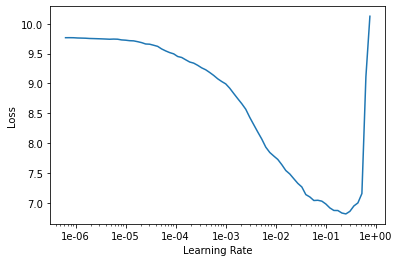

In [12]:
learn.recorder.plot()

**bold text**###Train

In [13]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.014753,2.015110,0.686046,0.490207,05:45
1,1.272010,1.242527,0.787423,0.572212,05:40
2,0.773901,0.707492,0.872055,0.694512,05:45
3,0.515184,0.446711,0.919250,0.787786,05:51
4,0.388626,0.272518,0.954171,0.872141,05:47
5,0.240096,0.202539,0.968603,0.910192,05:53
6,0.185306,0.173153,0.975078,0.928544,05:47


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save(path/'transformer_co1')

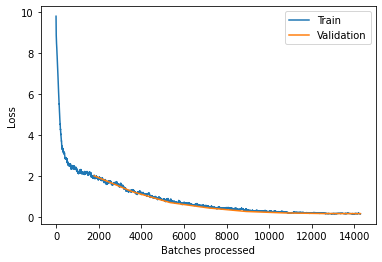

In [15]:
learn.recorder.plot_losses()

In [16]:
inputs, targets, outputs = get_predictions(learn)

In [17]:
print(inputs[10],'\n',targets[10],'\n',outputs[10],'\n')
print(inputs[700],'\n',targets[700],'\n',outputs[700],'\n')
# print(inputs[701],'\n',targets[701],'\n',outputs[701]),'\n')
print(inputs[2500],'\n',targets[2500],'\n',outputs[2500],'\n')
print(inputs[4002],'\n',targets[4002],'\n',outputs[4002],'\n')

xxbos xxmaj amanzi , ingakumbi amanzi xxunk , xxunk umbane , kwaye ukuba athe adibana nesixhobo zikanomathotholo isixhobo sokunqanda umbane xxunk xxunk kwaye xxunk eziphezulu xxunk , nto leyo enokuthi ibangele umlilo kunye nomonakalo omandundu kuzo zonke izixhobo . 
 xxbos xxmaj water , especially salt water , conducts electricity , and if it reaches radio equipment the insulators will be rendered useless and the high voltages will flash over , causing burning and serious damage throughout the equipment 
 xxbos xxmaj water , especially salt water , trunking electricity , and if the covers radio equipment the lifejacket will be provided concrete and the actual beacon will float on , causing burning and serious damage throughout the equipment . 

xxbos amakaledi athetha ke kukumkani xxunk , athi , xxmaj kumkani , yidla ubomi ngonaphakade ! xxmaj xxunk abakhonzi bakho iphupha elo ; xxunk ukutyhilwa kwalo . 
 xxbos xxmaj then spoke the xxmaj chaldeans to the king in the xxmaj syrian langua